## Set-up environment

Let's first install 🤗 Transformers. We install from source as the model is brand new at the moment of writing.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load image

Next, let's load an image.

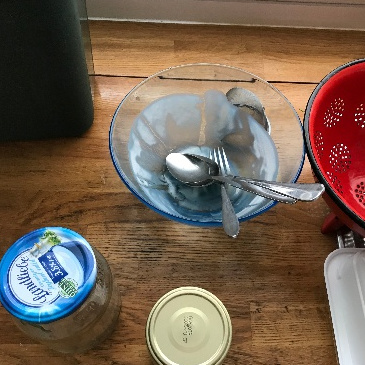

In [ ]:
from PIL import Image
import requests

url = "https://github.com/timojl/clipseg/blob/master/example_image.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image

## Load model

Next, let's load the model and its processor from the [hub](https://huggingface.co/CIDAS/clipseg-rd64-refined).

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

## Prepare image and texts for model

The image and a few prompts can be prepared for the model using the processor.

In [ ]:
prompts = ["a glass object", "object that is fillable", "wood", "a jar"]

inputs = processor(text=prompts, images=[image] * len(prompts), return_tensors="pt", padding=True)
inputs

Unused or unrecognized kwargs: padding.


{'input_ids': tensor([[49406,   320,  3313, 14115, 49407, 49407, 49407],
        [49406, 14115,   682,   533,  1142, 31879, 49407],
        [49406,  1704, 49407, 49407, 49407, 49407, 49407],
        [49406,   320, 10837, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0]]), 'pixel_values': tensor([[[[-1.8610, -1.8268, -1.8782,  ...,  0.0398,  0.0056,  0.0741],
          [-1.8610, -1.8439, -1.8439,  ..., -0.0116, -0.0801, -0.0458],
          [-1.8782, -1.8097, -1.8268,  ...,  0.0227,  0.0056,  0.0398],
          ...,
          [-0.1657, -0.0458, -0.1314,  ...,  1.1187,  1.0844,  1.1015],
          [-0.0629, -0.0116, -0.1999,  ...,  1.1187,  1.0844,  1.1015],
          [ 0.0398, -0.0629, -0.0972,  ...,  1.1187,  1.0844,  1.1015]],

         [[-1.7381, -1.7031, -1.7556,  ..., -0.3200, -0.3550, -0.2850],
          [-1.7381, -1.7206, -1.7206,  ..., -0.3550, -0.4251, -0.39

## Forward pass

Next, let's run a forward pass and visualize the predictions the model made.

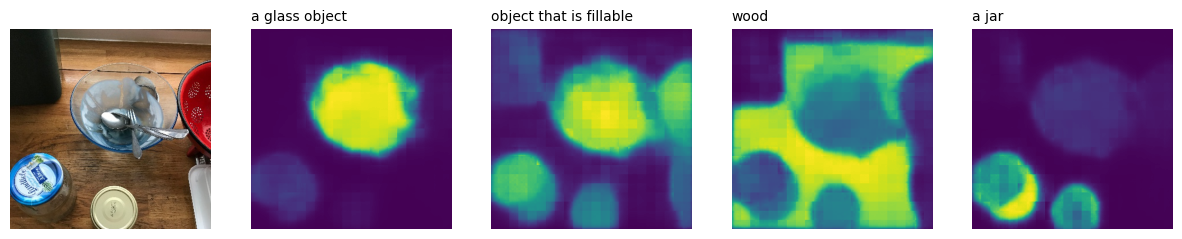

In [ ]:
import torch
import matplotlib.pyplot as plt

# predict
with torch.inference_mode():
  outputs = model(**inputs)

preds = outputs.logits.unsqueeze(1)

# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(4)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(4)];

As can be seen, the model is capable of segmenting images based on text prompts in a zero-shot manner. Pretty cool, huh?

## Convert to binary mask

To convert to a binary mask, I borrow some logic from [here](https://github.com/amrrs/stable-diffusion-prompt-inpainting). One can apply a sigmoid activation function on the predicted mask and use some OpenCV (cv2) to turn it into a binary mask.

In [ ]:
filename = f"mask.png"
# here we save the second mask
plt.imsave(filename,torch.sigmoid(preds[1][0]))

In [ ]:
import cv2

img2 = cv2.imread(filename)

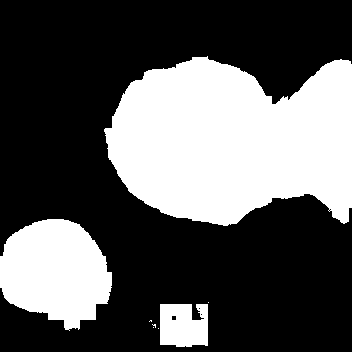

In [ ]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)